In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os

import pandas as pd

In [2]:
# Parameters from your acquisition
f0 = 123.0e6  # Resonance frequency (in Hz, e.g., 123 MHz for 3T)
SW = 1200  # Spectral width in Hz for our data
N = 512  # Number of data points
delta0 = 4.7  # Reference chemical shift (ppm), usually the water peak

# Create frequency axis in Hz
frequencies = np.fft.fftfreq(N, d=1/SW)

# Convert to ppm
#ppm = delta0 - (frequencies / f0)
ppm = frequencies /f0

# Ensure correct ordering if needed (positive frequencies first)
ppm_shift = np.fft.fftshift(ppm)

In [3]:
subjects_folder = "/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy"
# get list of directories in subjects_folder
subject_dirs = os.listdir(subjects_folder)
subject_dirs = [subject for subject in subject_dirs if not subject.startswith('.')]
print(f"Found {len(subject_dirs)} subjects")

Found 17 subjects


Processing MATHAI
Processing PADILLA
Processing BOYER
Processing LIN
Processing ADLER
Processing SHLAIN
Processing MACAULEY
Processing JAYANTHI
Processing RUNGE
Skipping RUNGE because /Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/RUNGE/SHAM/mrs-svs_task-post does not exist
Processing RAMNAUTH
Processing ALLAHABI
Processing GHOSH
Processing RAHMAN
Processing CABRERA
Processing RYAN
Processing COACHE
Processing AHMED


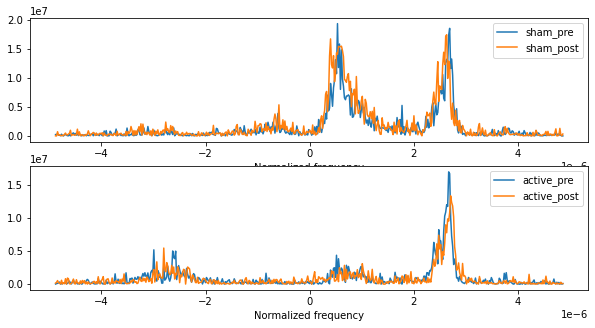

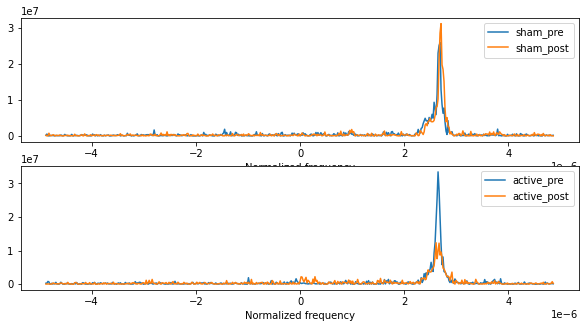

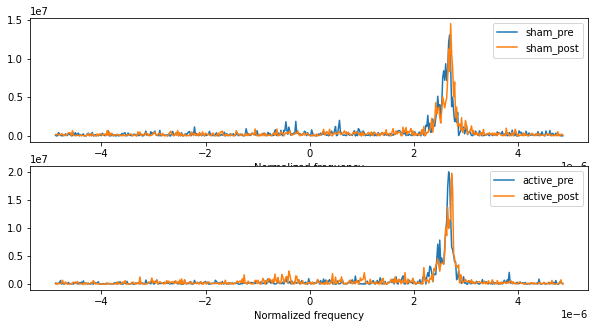

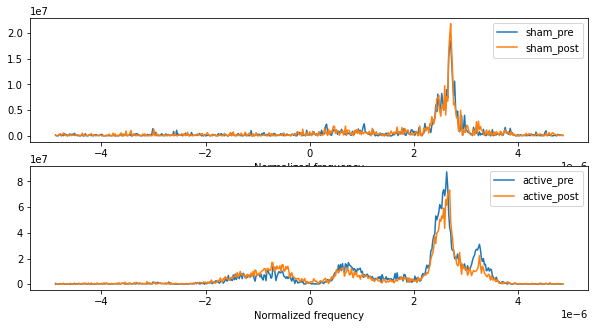

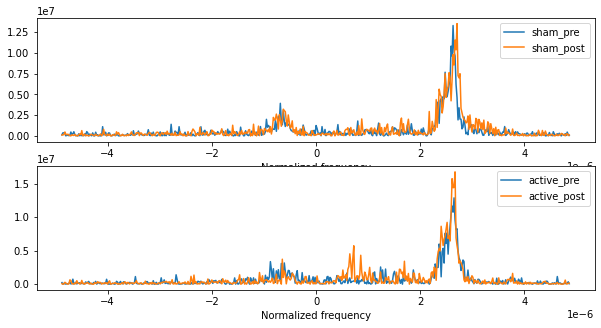

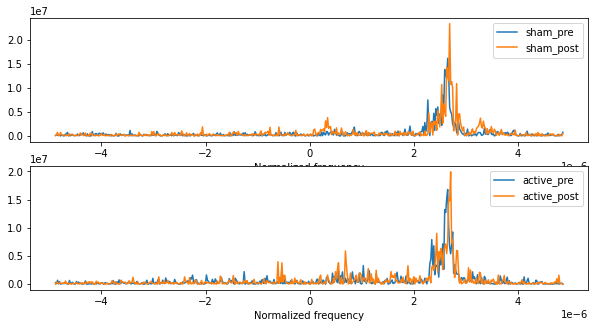

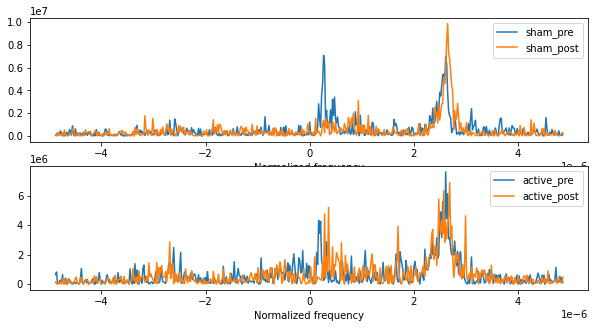

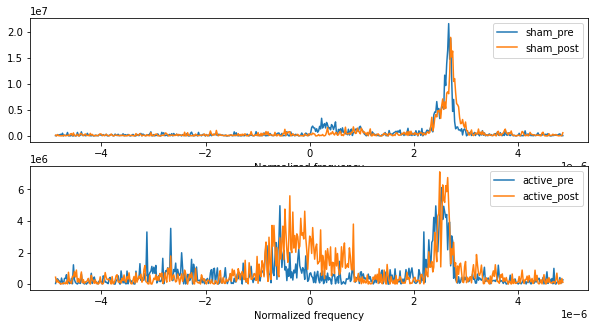

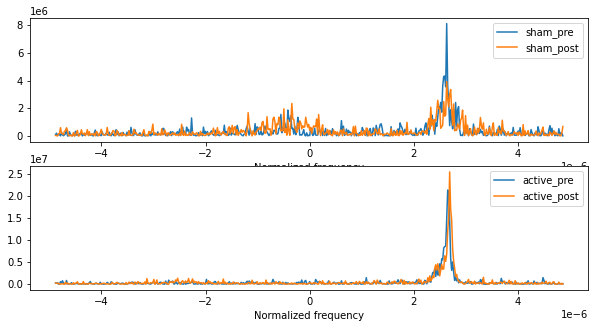

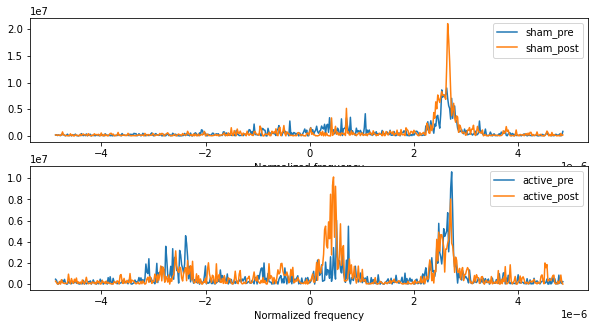

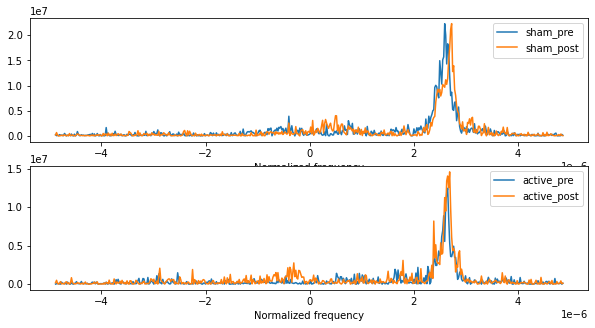

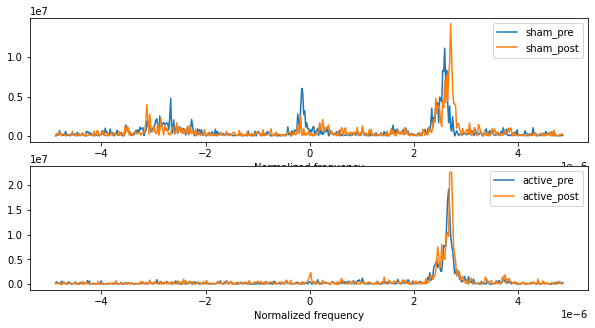

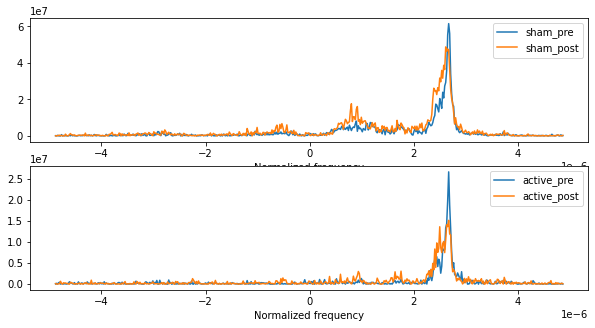

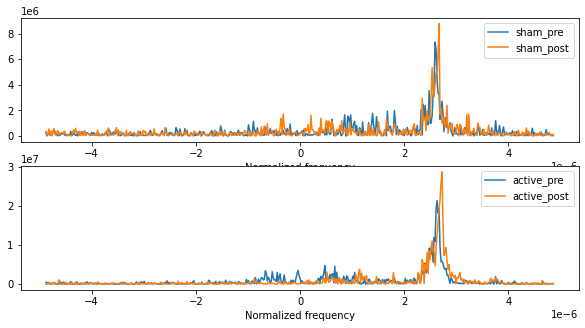

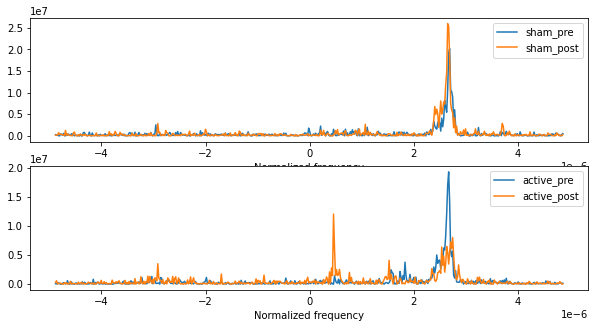

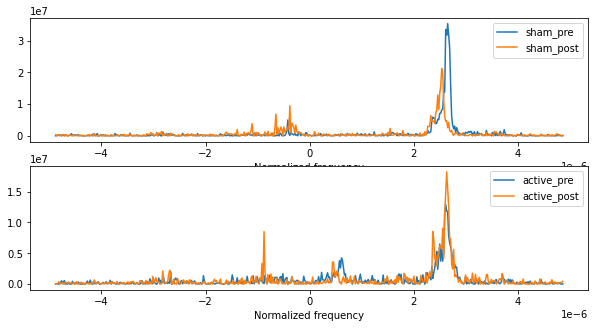

In [4]:
gaba=[] # list to store the gaba power in each session

for subject in subject_dirs:
    print(f"Processing {subject}")
    path_to_sham_post = f"/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/{subject}/SHAM/mrs-svs_task-post"
    path_to_sham_pre = f"/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/{subject}/SHAM/mrs-svs_task-pre"
    path_to_active_post = f"/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/{subject}/ACTIVE/mrs-svs_task-post"
    path_to_active_pre = f"/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/{subject}/ACTIVE/mrs-svs_task-pre"

    # verify that all four directories exist
    if not os.path.exists(path_to_sham_post):
        print(f"Skipping {subject} because {path_to_sham_post} does not exist")
        continue
    if not os.path.exists(path_to_sham_pre):
        print(f"Skipping {subject} because {path_to_sham_pre} does not exist")
        continue
    if not os.path.exists(path_to_active_post):
        print(f"Skipping {subject} because {path_to_active_post} does not exist")
        continue
    if not os.path.exists(path_to_active_pre):
        print(f"Skipping {subject} because {path_to_active_pre} does not exist")
        continue

    sham_post_file = os.listdir(path_to_sham_post)[0]
    path_to_sham_post = os.path.join(path_to_sham_post, sham_post_file)

    # find nii.gz file in path_to_sham_pre
    sham_pre_file = os.listdir(path_to_sham_pre)[0]
    path_to_sham_pre = os.path.join(path_to_sham_pre, sham_pre_file)

    # find nii.gz file in path_to_active_post
    active_post_file = os.listdir(path_to_active_post)[0]
    path_to_active_post = os.path.join(path_to_active_post, active_post_file)

    # find nii.gz file in path_to_active_pre
    active_pre_file = os.listdir(path_to_active_pre)[0]
    path_to_active_pre = os.path.join(path_to_active_pre, active_pre_file)

    paths = [path_to_sham_pre, path_to_sham_post, path_to_active_pre, path_to_active_post]
    labels = ['sham_pre', 'sham_post', 'active_pre', 'active_post']

    # load the niftis
    niis = [nib.load(path) for path in paths]

    # extract the time domain data (called the free induction decay or fid)
    fids = [np.squeeze(nii.get_fdata(dtype=np.complex64)) for nii in niis]

    # compute the power spectrum (magnitude squared of the fourier transform)
    powers = [np.abs(np.fft.fft(fid, axis=0)) ** 2 for fid in fids]
    powers_shift = [np.fft.fftshift(power, axes=0) for power in powers]

    # compute the frequency axis
    freqs = np.fft.fftfreq(len(fids[0]), 1)  # second parameter is the inverse of the sampling rate
    freqs_shift = np.fft.fftshift(freqs)

    # just the difference spectrum
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    for label, power in zip(labels,powers_shift):
        if label.startswith('sham'):
            ax[0].plot(ppm_shift, power[:, 2], label=label)
            ax[0].set_xlabel('Normalized frequency')
            #ax[0].plot(freqs_shift, np.fft.fftshift(power[:, 2]), label=label)
        else:
            ax[1].plot(ppm_shift, power[:, 2], label=label)
            ax[1].set_xlabel('Normalized frequency')
            #ax[1].plot(freqs_shift, np.fft.fftshift(power[:, 2]), label=label)
    ax[0].legend()
    ax[1].legend()

    # save figure to disk
    #fig.tight_layout()
    # replace the subject string with random characters
    #subject = ''.join([chr(np.random.randint(65, 91)) for _ in range(5)])
    #fig.savefig(f'/Users/jacekdmochowski/PROJECTS/fus/data/mrs_working/{subject}.png', dpi=300)

    # crude analysis of power in the GABA range
    f_begin = np.where(freqs_shift>0.22)[0][0] # the first frequency above 0.2
    f_end = np.where(freqs_shift>0.28)[0][0] # the first frequency above 0.3
    #gaba.append([np.mean(power[f_begin:f_end,2]) for power in powers_shift])
    gaba.append([np.max(power[f_begin:f_end,2]) for power in powers_shift])

    ## all three dicoms (not just the GABA subtracted image)
    #fig, ax = plt.subplots(3, 1, figsize=(15, 5))
    #for label, power in zip(labels,powers):
    #    ax[0].plot(freqs_shift, np.fft.fftshift(power[:, 0]), label=label)
    #    ax[1].plot(freqs_shift, np.fft.fftshift(power[:, 1]), label=label)
    #    ax[2].plot(freqs_shift, np.fft.fftshift(power[:, 2]), label=label)
    #ax[0].legend()


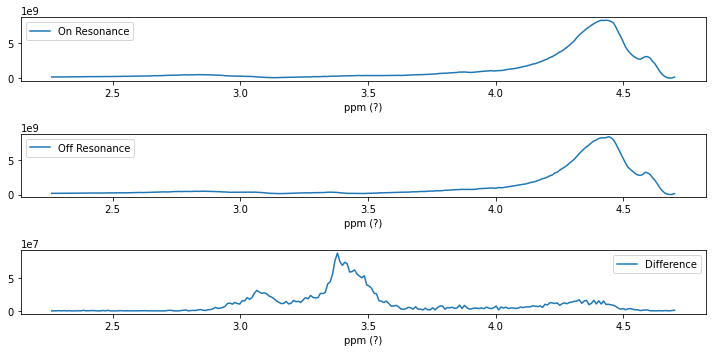

In [6]:
# validate ppm axis
subject = "LIN"
cond = "ACTIVE"
path_to_active_pre = f"/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/{subject}/{cond}/mrs-svs_task-pre"
active_pre_file = os.listdir(path_to_active_pre)[0]
active_pre_file = os.path.join(path_to_active_pre, active_pre_file)

# load the niftis
nii = nib.load(active_pre_file)
fid = np.squeeze(nii.get_fdata(dtype=np.complex64))
power = np.abs(np.fft.fft(fid, axis=0)) ** 2
power_shift = np.fft.fftshift(power, axes=0)
power_shift_pos = power_shift[N//2:]

SW = 600  # Spectral width in Hz
f0 = 123e6  # Resonance frequency in Hz (123 MHz)
delta0 = 4.7  # Reference ppm (water)
N = 512  # Number of samples

# Create frequency axis from 0 to SW/2 (positive frequencies)
frequencies = np.linspace(0, SW/2, N//2)

# Convert to ppm
ppm = delta0 - (frequencies / f0) * 1e6  # Hz to ppm

fig, ax = plt.subplots(3, 1, figsize=(10, 5))
ax[0].plot(ppm, power_shift_pos[:, 0], label="On Resonance")
ax[0].set_xlabel('ppm (?)')

ax[1].plot(ppm, power_shift_pos[:, 1], label="Off Resonance")
ax[1].set_xlabel('ppm (?)')

ax[2].plot(ppm, power_shift_pos[:, 2], label="Difference")
ax[2].set_xlabel('ppm (?)')

ax[0].legend()
ax[1].legend()
ax[2].legend()

fig.tight_layout()



In [9]:
type(fid), fid.shape

(numpy.ndarray, (512, 3))

In [ ]:
np_gaba = np.array(gaba)

df = pd.DataFrame(np_gaba, columns=labels)

df['del_active'] = (df['active_post'] - df['active_pre']) / df['active_pre']
df['del_sham'] = (df['sham_post'] - df['sham_pre']) / df['sham_pre']

df['del_sham'].ge(0).mean(), df['del_active'].ge(0).mean()


In [ ]:
# add a row containing the mean
df.loc['mean'] = df.mean()
df.loc['median'] = df.median()

In [ ]:
# t-test for active vs sham
from scipy.stats import ttest_ind
ttest_ind(df['del_active'], df['del_sham'])

In [ ]:
# wilcoxon signed rank test
from scipy.stats import wilcoxon
wilcoxon(df['del_active'], df['del_sham'])

In [ ]:
df.plot( y = ['active_pre','active_post'], kind = 'bar')
df.plot( y = ['sham_pre','sham_post'], kind = 'bar')

## SCRATCH

In [ ]:
# This code was used to figure out how to convert dicoms to niftis
"""
import numpy as np
import nibabel as nib
import subprocess
import os

# specify where the raw dicoms are located

path_to_dcm_pre = "/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/ADLER/ACTIVE/mrs-svs_task-pre/sub-ADLER_ses-ACTIVE_acq-mrs-svs_task-pre"

path_to_dcm_post = "/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/ADLER/ACTIVE/mrs-svs_task-post/sub-ADLER_ses-ACTIVE_acq-mrs-svs_task-post"

# examine the contents of path_to_dcm_pre
os.listdir(path_to_dcm_pre), os.listdir(path_to_dcm_post)

# specify where we would like the niftis to be written to
path_to_output_nii_pre = '/Users/jacekdmochowski/PROJECTS/fus/data/mrs_working/tmp/tmp_pre'
path_to_output_nii_post = '/Users/jacekdmochowski/PROJECTS/fus/data/mrs_working/tmp/tmp_post'
# convert dicoms to nifti
subprocess.run(["spec2nii", "dicom", "-f", path_to_output_nii_pre, path_to_dcm_pre])
subprocess.run(["spec2nii", "dicom", "-f", path_to_output_nii_post, path_to_dcm_post])
"""

In [ ]:
# I used this to try and figure out the spectral width parameter of the MRS
# This is apparently needed to convert the data to ppm
"""
import pydicom
from nibabel.nicom import csareader

# Load the DICOM file
dicom_file_path = '/Users/jacekdmochowski/PROJECTS/fus/data/mrs_working/sample.dicom/sample_2.dcm'
dicom_data = pydicom.dcmread(dicom_file_path)

# Print all available data elements to explore relevant tags
for elem in dicom_data:
    print(elem)

# Look for specific fields related to spectral width or MR spectroscopy parameters
try:
    spectral_width = dicom_data[0x0018, 0x9050]  # Example of a DICOM tag for spectral width
    print(f"Spectral Width: {spectral_width}")
except KeyError:
    print("Spectral width not found.")


# get the values of tag (0029, 1108) [CSA Image Header Type]
tags = dicom_data[0x0029, 0x1120].value
"""